### Imports

In [1]:
# uncomment and run only to update local branch of tpg
# current local branch [June 4 2021]: new-tpg 
# pip install ../PyTPG/.

In [2]:
import numpy as np
import random
# import to do training
from tpg.trainer import Trainer
# import to run an agent (always needed)
from tpg.agent import Agent
# faster training
import multiprocessing as mp
# visual tools
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import pandas as pd
# for writing
import csv
from datetime import date

In [3]:
def animate_path(sequence):
    current_map = np.zeros((10, 10))
    # add barrier
    for i in range(5):
        current_map[(4, i)] = 5
    # animate the run!
    for i in range(len(sequence)):
        time.sleep(0.5)
        if i == 0:
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(0)
            print(current_map)
        else:
            current_map[sequence[i-1]] = 0
            current_map[sequence[i]] = 1
            clear_output(wait=True)
            print(i)
            print(current_map)

In [4]:
# example of above 
seq = [(0,1), (0,2), (0, 3), (1, 3), (2, 4)]
animate_path(seq)

4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [5]:
# todo: make generalizable for any GridWorld
def heat_map(sequence):
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    plt.xticks(ticks=np.arange(len(x)),labels=x)
    plt.yticks(ticks=np.arange(len(y)),labels=y)
    plt.imshow(sequence, cmap='cool')

### Grid World

### Fig 11 (Downing)

In [6]:
# will use Downing fig 11 for testing on this
class Figure11:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (1, 2)) or (next == (1, 3)) or (next == (2, 2)) or (next == (2, 3)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(1, 2)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 2)] = 5
        current_map[(2, 3)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### Fig 12 (Downing)

In [7]:
# will use Downing fig 12 for testing on this
class Figure12:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (2, 0)) or (next == (1, 1)) or (next == (2, 1)) or (next == (1, 3)) or (next == (2, 3)) or (next == (2, 4)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(2, 0)] = 5
        current_map[(1, 1)] = 5
        current_map[(2, 1)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 3)] = 5
        current_map[(2, 4)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### Fig 13 (Downing)

In [8]:
# will use Downing fig 13 for testing on this
class Figure13:
    def __init__ (self, rows, cols, win_state, start_state):
        self.memory = []
        self.memory_position = 0
        self.memory_limit = 20
        self.rows = rows
        self.cols = cols
        self.start_state = start_state
        self.win_state = win_state
        self.current_state = self.start_state
        
    def sample_action (self):
        rand = random.uniform(0, 1)
        if (rand >= 0) and (rand < 0.25):
            return 0
        elif (rand >= 0.25) and (rand < 0.5):
            return 1
        elif (rand >= 0.5) and (rand < 0.75):
            return 2
        else:
            return 3
        
    def reset (self):
        self.current_state = self.start_state
        return self.current_state
        
    # just reset for now...
    def close (self):
        self.current_state = self.start_state
        return 1
    
    def check_win (self):
        if self.current_state == self.win_state:
            return True
        return False
    
    def step (self, action):
        # north
        if action == 0:
            next = (self.current_state[0] - 1, self.current_state[1])
        # south
        elif action == 1:
            next = (self.current_state[0] + 1, self.current_state[1])
        # east
        elif action == 2:
            next = (self.current_state[0], self.current_state[1] + 1)
        # west
        else:
            next = (self.current_state[0], self.current_state[1] - 1)

        terminate = False
        reward = 0
        # check if move is legal
        if (next[0] >= 0 and next[0] <= (self.rows-1)) and (next[1] >= 0 and next[1] <= (self.cols-1)):            
            illegal = 0
            if (next == (2, 0)) or (next == (1, 1)) or (next == (2, 1)) or (next == (1, 3)) or (next == (2, 3)) or (next == (3, 3)) or (next == (3, 4)):
                illegal = 1
                    
            if (illegal == 0):
                self.current_state = next
                reward += 0.1
                #reward -= 0.01
            else:
                reward -= 0.01
                #reward -= 1
                #reward = reward
        else:
            reward -= 0.01
            #reward -= 1
            #reward = reward
            
        # punish repeat states within last 20 states
        if self.current_state in self.memory:
            reward -= 0.01
            #reward -= 1
            #reward = reward
        
        if self.check_win():
            print('Winner Winner Chicken Dinner!')
            reward += 100
            terminate = True
        
        # add new state to memory
        if len(self.memory) <= self.memory_limit:
            (self.memory).append(self.current_state)
        # after memory is full, begin overriding it
        else:
            if self.memory_position < self.memory_limit:
                self.memory[self.memory_position] = self.current_state
                self.memory_position += 1
            else:
                self.memory_position = 0
                self.memory[self.memory_position] = self.current_state
        
        return self.current_state, reward, terminate
    
    def animate_path(self, sequence):
        current_map = np.zeros((5, 5))
        # add barrier
        current_map[(2, 0)] = 5
        current_map[(1, 1)] = 5
        current_map[(2, 1)] = 5
        current_map[(1, 3)] = 5
        current_map[(2, 3)] = 5
        current_map[(3, 3)] = 5
        current_map[(3, 4)] = 5
        current_map[self.win_state] = 8

        # animate the run!
        for i in range(len(sequence)):
            time.sleep(0.5)
            if i == 0:
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(0)
                print(current_map)
            else:
                current_map[sequence[i-1]] = 0
                current_map[sequence[i]] = 1
                clear_output(wait=True)
                print(i)
                print(current_map)

### TPG Agent

In [9]:
def runAgent(args):
    agent = args[0]
    envName = args[1]
    scoreList = args[2]
    numEpisodes = args[3] # number of times to repeat game
    numFrames = args[4] 
    gen = args[5]
    
    # skip if task already done by agent
    if agent.taskDone(envName):
        print('Agent #' + str(agent.agentNum) + ' can skip.')
        scoreList.append((agent.team.id, agent.team.outcomes))
        return
    
    if envName == 'fig11':
        env = Figure11(5, 5, (0, 4), (4, 0))
    elif envName == 'fig12':
        env = Figure12(5, 5, (0, 4), (4, 0))
    else:
        env = Figure13(5, 5, (2, 4), (4, 0))

    valActs = 4
    
    # create environment object from above
    scoreTotal = 0
    for ep in range(numEpisodes):
        state = env.reset()
        scoreEp = 0
        states = []
        step_map = np.zeros((10, 10))
        if numEpisodes > 1:
            for i in range(numFrames): # frame loop           
                # action selection
                act = agent.act(state)
                
                state, reward, isDone = env.step(act)
                # for heatmap
                step_map[state] = step_map[state] + 1
                states.append(state)
                #print('State: ' + str(state))
                scoreEp += reward
                
                # win
                if isDone:
                    print('win!')
                    print(states)
                    break
                    
            print('Agent #' + str(agent.agentNum) + 
              ' | Ep #' + str(ep) + ' | Score: ' + str(scoreEp))
            
        scoreTotal += scoreEp
    scoreTotal /= numEpisodes
    env.close()
    agent.reward(scoreTotal, envName)
    scoreList.append((agent.team.id, agent.team.outcomes))
    if isDone:
        return states
    else:
        return 0

### All Together Now!

In [10]:
# NOTES:
# pAtomic equal to 1 so teams are single nodes
    # starting off, teams don't reference teams
# if the maxTeamSize is set, we can try to maximize the use of actually useful learners.
    # this might help with the consistency of success...
filename = 'results/' + str(date.today()) + '.csv'
runs = 1
save = 0
for trial in range(runs):
#     trainer = Trainer(actions=4, teamPopSize=50, pActAtom=1.0, 
#                       nRegisters=4, initMaxActProgSize=48, gap=0.5)
    trainer = Trainer(actions=4, teamPopSize=50, pActAtom=1.0, 
                      nRegisters=4, initMaxActProgSize=48, 
                      initMaxTeamSize=2, maxTeamSize=10, gap=0.5) # initMaxTeamSize=2, maxTeamSize=5

#    envName = 'fig11'
#    envName = 'fig12'
    envName = 'fig13'
    allScores = []
    champions = []
    
    num_gen = 50
    
    for gen in range(num_gen):
        scoreList = []

        agents = trainer.getAgents()

        agent_track = 0
        best_score = -200.0
        curr_champion = []
        for agent in agents:
            run = runAgent([agent, envName, scoreList, 10, 100, gen])
            if (scoreList[agent_track][1][envName] > best_score) and (run != 0):
                best_score = scoreList[agent_track][1][envName]
                curr_champion = run
                print(run)
            agent_track += 1
        
        champions.append(curr_champion)
        
        # apply scores, must do this when multiprocessing
        # because agents can't refer to trainer
        teams = trainer.applyScores(scoreList)

        trainer.evolve(tasks=[envName]) # go into next gen

        # an easier way to track stats than the above example
        scoreStats = trainer.fitnessStats

        allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))

        print('Gen: ' + str(gen))
        print('Results so far: ' + str(allScores))

#     print('Results:\nMin, Max, Avg')
#     for score in allScores:
#         print(score[0],score[1],score[2])
    
#     with open(filename, 'a') as csvfile: 
#         csvwriter = csv.writer(csvfile)
#         csvwriter.writerow([trial])
#         for champion in champions:
#             if champion != None:
#                 csvwriter.writerow(champion)
#         y = []
#         for score in allScores:
#             y.append(score[1])
#         csvwriter.writerow(y)
    # collect average and max scores to save to csv
    if save == 1:
        averages = []
        maxes = []
        for score in allScores:
            averages.append(score[2])
            maxes.append(score[1])    

        df = pd.DataFrame({
            'average_score': averages,
            'max_score': maxes,
        })

        df.to_csv('../results/'+str(envName)+'/tpg/'+str(trial)+'.csv')

Agent #0 | Ep #0 | Score: -1.9900000000000013
Agent #0 | Ep #1 | Score: -2.0000000000000013
Agent #0 | Ep #2 | Score: -2.0000000000000013
Agent #0 | Ep #3 | Score: -2.0000000000000013
Agent #0 | Ep #4 | Score: -2.0000000000000013
Agent #0 | Ep #5 | Score: -2.0000000000000013
Agent #0 | Ep #6 | Score: -2.0000000000000013
Agent #0 | Ep #7 | Score: -2.0000000000000013
Agent #0 | Ep #8 | Score: -2.0000000000000013
Agent #0 | Ep #9 | Score: -2.0000000000000013
Agent #1 | Ep #0 | Score: -1.7600000000000011
Agent #1 | Ep #1 | Score: -2.0000000000000013
Agent #1 | Ep #2 | Score: -2.0000000000000013
Agent #1 | Ep #3 | Score: -2.0000000000000013
Agent #1 | Ep #4 | Score: -2.0000000000000013
Agent #1 | Ep #5 | Score: -2.0000000000000013
Agent #1 | Ep #6 | Score: -2.0000000000000013
Agent #1 | Ep #7 | Score: -2.0000000000000013
Agent #1 | Ep #8 | Score: -2.0000000000000013
Agent #1 | Ep #9 | Score: -2.0000000000000013
Agent #2 | Ep #0 | Score: -1.5100000000000011
Agent #2 | Ep #1 | Score: -1.53000

Agent #18 | Ep #0 | Score: -1.640000000000001
Agent #18 | Ep #1 | Score: -1.5200000000000011
Agent #18 | Ep #2 | Score: -1.530000000000001
Agent #18 | Ep #3 | Score: -1.530000000000001
Agent #18 | Ep #4 | Score: -1.0500000000000012
Agent #18 | Ep #5 | Score: -1.5200000000000011
Agent #18 | Ep #6 | Score: -1.0500000000000012
Agent #18 | Ep #7 | Score: -1.0600000000000012
Agent #18 | Ep #8 | Score: -1.0600000000000012
Agent #18 | Ep #9 | Score: -1.0600000000000012
Agent #19 | Ep #0 | Score: -1.9900000000000013
Agent #19 | Ep #1 | Score: -2.0000000000000013
Agent #19 | Ep #2 | Score: -2.0000000000000013
Agent #19 | Ep #3 | Score: -2.0000000000000013
Agent #19 | Ep #4 | Score: -2.0000000000000013
Agent #19 | Ep #5 | Score: -2.0000000000000013
Agent #19 | Ep #6 | Score: -2.0000000000000013
Agent #19 | Ep #7 | Score: -2.0000000000000013
Agent #19 | Ep #8 | Score: -2.0000000000000013
Agent #19 | Ep #9 | Score: -2.0000000000000013
Agent #20 | Ep #0 | Score: -1.9900000000000013
Agent #20 | Ep #

Agent #42 | Ep #5 | Score: -1.530000000000001
Agent #42 | Ep #6 | Score: -1.530000000000001
Agent #42 | Ep #7 | Score: -1.530000000000001
Agent #42 | Ep #8 | Score: -1.530000000000001
Agent #42 | Ep #9 | Score: -1.530000000000001
Agent #43 | Ep #0 | Score: -1.8800000000000012
Agent #43 | Ep #1 | Score: -1.8900000000000012
Agent #43 | Ep #2 | Score: -1.8900000000000012
Agent #43 | Ep #3 | Score: -1.8900000000000012
Agent #43 | Ep #4 | Score: -1.8900000000000012
Agent #43 | Ep #5 | Score: -1.8900000000000012
Agent #43 | Ep #6 | Score: -1.8900000000000012
Agent #43 | Ep #7 | Score: -1.8900000000000012
Agent #43 | Ep #8 | Score: -1.8900000000000012
Agent #43 | Ep #9 | Score: -1.8900000000000012
Agent #44 | Ep #0 | Score: -1.8800000000000012
Agent #44 | Ep #1 | Score: -1.8900000000000012
Agent #44 | Ep #2 | Score: -1.8900000000000012
Agent #44 | Ep #3 | Score: -1.8900000000000012
Agent #44 | Ep #4 | Score: -1.8900000000000012
Agent #44 | Ep #5 | Score: -1.8900000000000012
Agent #44 | Ep #6 

Agent #36 | Ep #7 | Score: -1.530000000000001
Agent #36 | Ep #8 | Score: -1.530000000000001
Agent #36 | Ep #9 | Score: -1.530000000000001
Agent #37 | Ep #0 | Score: -1.8800000000000012
Agent #37 | Ep #1 | Score: -1.8900000000000012
Agent #37 | Ep #2 | Score: -1.8900000000000012
Agent #37 | Ep #3 | Score: -1.8900000000000012
Agent #37 | Ep #4 | Score: -1.8900000000000012
Agent #37 | Ep #5 | Score: -1.8900000000000012
Agent #37 | Ep #6 | Score: -1.8900000000000012
Agent #37 | Ep #7 | Score: -1.8900000000000012
Agent #37 | Ep #8 | Score: -1.8900000000000012
Agent #37 | Ep #9 | Score: -1.8900000000000012
Agent #38 | Ep #0 | Score: -1.8800000000000012
Agent #38 | Ep #1 | Score: -1.8900000000000012
Agent #38 | Ep #2 | Score: -1.8900000000000012
Agent #38 | Ep #3 | Score: -1.8900000000000012
Agent #38 | Ep #4 | Score: -1.8900000000000012
Agent #38 | Ep #5 | Score: -1.8900000000000012
Agent #38 | Ep #6 | Score: -1.8900000000000012
Agent #38 | Ep #7 | Score: -1.8900000000000012
Agent #38 | Ep #

Agent #32 | Ep #6 | Score: -1.530000000000001
Agent #32 | Ep #7 | Score: -1.530000000000001
Agent #32 | Ep #8 | Score: -1.530000000000001
Agent #32 | Ep #9 | Score: -1.530000000000001
Agent #33 | Ep #0 | Score: -1.5200000000000011
Agent #33 | Ep #1 | Score: -1.530000000000001
Agent #33 | Ep #2 | Score: -1.530000000000001
Agent #33 | Ep #3 | Score: -1.530000000000001
Agent #33 | Ep #4 | Score: -1.530000000000001
Agent #33 | Ep #5 | Score: -1.530000000000001
Agent #33 | Ep #6 | Score: -1.530000000000001
Agent #33 | Ep #7 | Score: -1.530000000000001
Agent #33 | Ep #8 | Score: -1.530000000000001
Agent #33 | Ep #9 | Score: -1.530000000000001
Agent #34 | Ep #0 | Score: -1.8800000000000012
Agent #34 | Ep #1 | Score: -1.8900000000000012
Agent #34 | Ep #2 | Score: -1.650000000000001
Agent #34 | Ep #3 | Score: -1.5200000000000011
Agent #34 | Ep #4 | Score: -1.530000000000001
Agent #34 | Ep #5 | Score: -1.530000000000001
Agent #34 | Ep #6 | Score: -1.530000000000001
Agent #34 | Ep #7 | Score: -1.

Agent #39 | Ep #4 | Score: -2.0000000000000013
Agent #39 | Ep #5 | Score: -2.0000000000000013
Agent #39 | Ep #6 | Score: -2.0000000000000013
Agent #39 | Ep #7 | Score: -2.0000000000000013
Agent #39 | Ep #8 | Score: -2.0000000000000013
Agent #39 | Ep #9 | Score: -2.0000000000000013
Agent #40 | Ep #0 | Score: -1.8800000000000012
Agent #40 | Ep #1 | Score: -1.8900000000000012
Agent #40 | Ep #2 | Score: -1.8900000000000012
Agent #40 | Ep #3 | Score: -1.8900000000000012
Agent #40 | Ep #4 | Score: -1.8900000000000012
Agent #40 | Ep #5 | Score: -1.8900000000000012
Agent #40 | Ep #6 | Score: -1.8900000000000012
Agent #40 | Ep #7 | Score: -1.8900000000000012
Agent #40 | Ep #8 | Score: -1.8900000000000012
Agent #40 | Ep #9 | Score: -1.8900000000000012
Agent #41 | Ep #0 | Score: -1.5200000000000011
Agent #41 | Ep #1 | Score: -1.530000000000001
Agent #41 | Ep #2 | Score: -1.530000000000001
Agent #41 | Ep #3 | Score: -1.530000000000001
Agent #41 | Ep #4 | Score: -1.530000000000001
Agent #41 | Ep #5

Agent #33 | Ep #0 | Score: -1.510000000000001
Agent #33 | Ep #1 | Score: -1.520000000000001
Agent #33 | Ep #2 | Score: -1.520000000000001
Agent #33 | Ep #3 | Score: -1.520000000000001
Agent #33 | Ep #4 | Score: -1.520000000000001
Agent #33 | Ep #5 | Score: -1.520000000000001
Agent #33 | Ep #6 | Score: -1.520000000000001
Agent #33 | Ep #7 | Score: -1.520000000000001
Agent #33 | Ep #8 | Score: -1.520000000000001
Agent #33 | Ep #9 | Score: -1.520000000000001
Agent #34 | Ep #0 | Score: -1.7600000000000011
Agent #34 | Ep #1 | Score: -2.0000000000000013
Agent #34 | Ep #2 | Score: -2.0000000000000013
Agent #34 | Ep #3 | Score: 2.8499999999999988
Agent #34 | Ep #4 | Score: 5.369999999999997
Agent #34 | Ep #5 | Score: 5.259999999999997
Agent #34 | Ep #6 | Score: 5.259999999999998
Agent #34 | Ep #7 | Score: 5.259999999999998
Agent #34 | Ep #8 | Score: 5.369999999999998
Agent #34 | Ep #9 | Score: 5.259999999999998
Agent #35 | Ep #0 | Score: -1.5200000000000011
Agent #35 | Ep #1 | Score: -1.530000

Agent #41 | Ep #3 | Score: -1.530000000000001
Agent #41 | Ep #4 | Score: -1.530000000000001
Agent #41 | Ep #5 | Score: -1.530000000000001
Agent #41 | Ep #6 | Score: -1.530000000000001
Agent #41 | Ep #7 | Score: -1.530000000000001
Agent #41 | Ep #8 | Score: -1.530000000000001
Agent #41 | Ep #9 | Score: -1.530000000000001
Agent #42 | Ep #0 | Score: -1.5100000000000011
Agent #42 | Ep #1 | Score: -1.530000000000001
Agent #42 | Ep #2 | Score: -1.530000000000001
Agent #42 | Ep #3 | Score: 3.5399999999999983
Agent #42 | Ep #4 | Score: 6.279999999999998
Agent #42 | Ep #5 | Score: 6.379999999999998
Agent #42 | Ep #6 | Score: 6.379999999999998
Agent #42 | Ep #7 | Score: 6.089999999999998
Agent #42 | Ep #8 | Score: 6.179999999999998
Agent #42 | Ep #9 | Score: 6.399999999999998
Agent #43 | Ep #0 | Score: -1.8800000000000012
Agent #43 | Ep #1 | Score: -1.8900000000000012
Agent #43 | Ep #2 | Score: -1.8900000000000012
Agent #43 | Ep #3 | Score: -1.8900000000000012
Agent #43 | Ep #4 | Score: -1.89000

Gen: 6
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982)]
Agent #0 can skip.
None
Agent #1 can skip.
Agent #2 can skip.
None
Agent #3 can skip.
None
Agent #4 can skip.
Agent #5 can skip.
Agent #6 can skip.
Agent #7 can skip.
Agent #8 can skip.
Agent #9 can skip.
Agent #10 can skip.
Agent #11 can skip.
Agent #12 can skip.
Agent #13 can skip.
Agent #14 can skip.
Agent #15 can skip.
Agent #16 can skip.
Agent #17 can skip.
Agent #18 can skip.
Agent #19 can skip.
Agent #20 can skip.
Agent #21 can skip.
Agent #22 can skip.
Agent #23 can skip.
Agent #24 can skip.
Agent #25 | Ep #0 | Score: -1.9900

Agent #41 | Ep #0 | Score: 3.819999999999997
Agent #41 | Ep #1 | Score: 3.8999999999999972
Agent #41 | Ep #2 | Score: 3.7899999999999974
Agent #41 | Ep #3 | Score: -1.110000000000001
Agent #41 | Ep #4 | Score: -2.0000000000000013
Agent #41 | Ep #5 | Score: -2.0000000000000013
Agent #41 | Ep #6 | Score: -2.0000000000000013
Agent #41 | Ep #7 | Score: -2.0000000000000013
Agent #41 | Ep #8 | Score: -2.0000000000000013
Agent #41 | Ep #9 | Score: -2.0000000000000013
Agent #42 | Ep #0 | Score: 3.999999999999996
Agent #42 | Ep #1 | Score: 3.519999999999997
Agent #42 | Ep #2 | Score: 2.3099999999999987
Agent #42 | Ep #3 | Score: -1.5200000000000011
Agent #42 | Ep #4 | Score: -1.530000000000001
Agent #42 | Ep #5 | Score: -1.530000000000001
Agent #42 | Ep #6 | Score: -1.530000000000001
Agent #42 | Ep #7 | Score: -1.530000000000001
Agent #42 | Ep #8 | Score: -1.530000000000001
Agent #42 | Ep #9 | Score: -1.530000000000001
Agent #43 | Ep #0 | Score: -1.8800000000000012
Agent #43 | Ep #1 | Score: -1

Agent #32 | Ep #0 | Score: -1.7500000000000013
Agent #32 | Ep #1 | Score: -2.0000000000000013
Agent #32 | Ep #2 | Score: -2.0000000000000013
Agent #32 | Ep #3 | Score: -1.520000000000001
Agent #32 | Ep #4 | Score: -1.520000000000001
Agent #32 | Ep #5 | Score: -1.530000000000001
Agent #32 | Ep #6 | Score: -1.530000000000001
Agent #32 | Ep #7 | Score: -1.530000000000001
Agent #32 | Ep #8 | Score: -1.520000000000001
Agent #32 | Ep #9 | Score: -1.530000000000001
Agent #33 | Ep #0 | Score: -1.5200000000000011
Agent #33 | Ep #1 | Score: -1.530000000000001
Agent #33 | Ep #2 | Score: -1.530000000000001
Agent #33 | Ep #3 | Score: -1.530000000000001
Agent #33 | Ep #4 | Score: -1.530000000000001
Agent #33 | Ep #5 | Score: -1.530000000000001
Agent #33 | Ep #6 | Score: -1.530000000000001
Agent #33 | Ep #7 | Score: -1.530000000000001
Agent #33 | Ep #8 | Score: -1.530000000000001
Agent #33 | Ep #9 | Score: -1.530000000000001
Agent #34 | Ep #0 | Score: 8.79999999999999
Agent #34 | Ep #1 | Score: 8.999

Agent #26 | Ep #4 | Score: -1.8900000000000012
Agent #26 | Ep #5 | Score: -1.8900000000000012
Agent #26 | Ep #6 | Score: -1.8900000000000012
Agent #26 | Ep #7 | Score: -1.8900000000000012
Agent #26 | Ep #8 | Score: -1.8900000000000012
Agent #26 | Ep #9 | Score: -1.8900000000000012
Agent #27 | Ep #0 | Score: -1.5200000000000011
Agent #27 | Ep #1 | Score: -1.530000000000001
Agent #27 | Ep #2 | Score: -1.530000000000001
Agent #27 | Ep #3 | Score: -1.530000000000001
Agent #27 | Ep #4 | Score: -1.530000000000001
Agent #27 | Ep #5 | Score: -1.530000000000001
Agent #27 | Ep #6 | Score: -1.530000000000001
Agent #27 | Ep #7 | Score: -1.530000000000001
Agent #27 | Ep #8 | Score: -1.530000000000001
Agent #27 | Ep #9 | Score: -1.530000000000001
Agent #28 | Ep #0 | Score: -1.8800000000000012
Agent #28 | Ep #1 | Score: -1.8900000000000012
Agent #28 | Ep #2 | Score: -1.8900000000000012
Agent #28 | Ep #3 | Score: -1.8900000000000012
Agent #28 | Ep #4 | Score: -1.8900000000000012
Agent #28 | Ep #5 | Sc

Agent #30 | Ep #1 | Score: 8.88999999999999
Agent #30 | Ep #2 | Score: 8.88999999999999
Agent #30 | Ep #3 | Score: 8.88999999999999
Agent #30 | Ep #4 | Score: 8.88999999999999
Agent #30 | Ep #5 | Score: 8.88999999999999
Agent #30 | Ep #6 | Score: 8.88999999999999
Agent #30 | Ep #7 | Score: 8.88999999999999
Agent #30 | Ep #8 | Score: 8.88999999999999
Agent #30 | Ep #9 | Score: 8.88999999999999
Agent #31 | Ep #0 | Score: -1.510000000000001
Agent #31 | Ep #1 | Score: -1.520000000000001
Agent #31 | Ep #2 | Score: -1.520000000000001
Agent #31 | Ep #3 | Score: -1.520000000000001
Agent #31 | Ep #4 | Score: -1.520000000000001
Agent #31 | Ep #5 | Score: -1.520000000000001
Agent #31 | Ep #6 | Score: -1.520000000000001
Agent #31 | Ep #7 | Score: -1.520000000000001
Agent #31 | Ep #8 | Score: -1.520000000000001
Agent #31 | Ep #9 | Score: -1.520000000000001
Agent #32 | Ep #0 | Score: -1.9900000000000013
Agent #32 | Ep #1 | Score: -2.0000000000000013
Agent #32 | Ep #2 | Score: -2.0000000000000013
Age

Agent #34 | Ep #7 | Score: -1.0500000000000007
Agent #34 | Ep #8 | Score: -1.0500000000000007
Agent #34 | Ep #9 | Score: -1.0500000000000005
Agent #35 | Ep #0 | Score: 9.01999999999999
Agent #35 | Ep #1 | Score: 8.999999999999991
Agent #35 | Ep #2 | Score: 8.999999999999991
Agent #35 | Ep #3 | Score: 8.999999999999991
Agent #35 | Ep #4 | Score: 8.999999999999991
Agent #35 | Ep #5 | Score: 8.999999999999991
Agent #35 | Ep #6 | Score: 8.999999999999991
Agent #35 | Ep #7 | Score: 8.999999999999991
Agent #35 | Ep #8 | Score: 8.999999999999991
Agent #35 | Ep #9 | Score: 8.999999999999991
Agent #36 | Ep #0 | Score: -1.8800000000000012
Agent #36 | Ep #1 | Score: -1.8900000000000012
Agent #36 | Ep #2 | Score: -1.8900000000000012
Agent #36 | Ep #3 | Score: -1.8900000000000012
Agent #36 | Ep #4 | Score: -1.7700000000000014
Agent #36 | Ep #5 | Score: -2.0000000000000013
Agent #36 | Ep #6 | Score: -2.0000000000000013
Agent #36 | Ep #7 | Score: -2.0000000000000013
Agent #36 | Ep #8 | Score: -2.0000

Agent #31 | Ep #8 | Score: -1.8800000000000012
Agent #31 | Ep #9 | Score: -1.8800000000000012
Agent #32 | Ep #0 | Score: 9.01999999999999
Agent #32 | Ep #1 | Score: 8.999999999999991
Agent #32 | Ep #2 | Score: 8.999999999999991
Agent #32 | Ep #3 | Score: 8.999999999999991
Agent #32 | Ep #4 | Score: 8.999999999999991
Agent #32 | Ep #5 | Score: 8.999999999999991
Agent #32 | Ep #6 | Score: 8.999999999999991
Agent #32 | Ep #7 | Score: 8.999999999999991
Agent #32 | Ep #8 | Score: 8.999999999999991
Agent #32 | Ep #9 | Score: 8.999999999999991
Agent #33 | Ep #0 | Score: -1.8800000000000012
Agent #33 | Ep #1 | Score: -1.8900000000000012
Agent #33 | Ep #2 | Score: -1.8900000000000012
Agent #33 | Ep #3 | Score: -1.8900000000000012
Agent #33 | Ep #4 | Score: -1.8900000000000012
Agent #33 | Ep #5 | Score: -1.8900000000000012
Agent #33 | Ep #6 | Score: -1.8900000000000012
Agent #33 | Ep #7 | Score: -1.8900000000000012
Agent #33 | Ep #8 | Score: -1.8900000000000012
Agent #33 | Ep #9 | Score: -1.8900

Gen: 12
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991)]
Agent #0 can skip.
None
Agent #1 can skip.
Agent #2 can skip.
Agent #3 can skip.
Agent #4 can skip.
Agent #5 can skip.
Agent #6 can skip.
Agent #7 can skip.
Agent #8 can skip.
Agent #9 can skip.

Agent #41 | Ep #9 | Score: -2.0000000000000013
Agent #42 | Ep #0 | Score: -1.9900000000000013
Agent #42 | Ep #1 | Score: -2.0000000000000013
Agent #42 | Ep #2 | Score: -2.0000000000000013
Agent #42 | Ep #3 | Score: -2.0000000000000013
Agent #42 | Ep #4 | Score: -2.0000000000000013
Agent #42 | Ep #5 | Score: -2.0000000000000013
Agent #42 | Ep #6 | Score: -2.0000000000000013
Agent #42 | Ep #7 | Score: -2.0000000000000013
Agent #42 | Ep #8 | Score: -2.0000000000000013
Agent #42 | Ep #9 | Score: -2.0000000000000013
Agent #43 | Ep #0 | Score: -1.8800000000000012
Agent #43 | Ep #1 | Score: -1.8900000000000012
Agent #43 | Ep #2 | Score: -1.8900000000000012
Agent #43 | Ep #3 | Score: 2.19
Agent #43 | Ep #4 | Score: 5.369999999999998
Agent #43 | Ep #5 | Score: 5.259999999999998
Agent #43 | Ep #6 | Score: 5.259999999999998
Agent #43 | Ep #7 | Score: 5.369999999999998
Agent #43 | Ep #8 | Score: 5.259999999999998
Agent #43 | Ep #9 | Score: 5.259999999999998
Agent #44 | Ep #0 | Score: -1.9900000000

Agent #35 | Ep #7 | Score: 8.88999999999999
Agent #35 | Ep #8 | Score: 8.88999999999999
Agent #35 | Ep #9 | Score: 8.88999999999999
Agent #36 | Ep #0 | Score: -1.8800000000000012
Agent #36 | Ep #1 | Score: -1.8900000000000012
Agent #36 | Ep #2 | Score: -1.8900000000000012
Agent #36 | Ep #3 | Score: -1.8900000000000012
Agent #36 | Ep #4 | Score: -1.8900000000000012
Agent #36 | Ep #5 | Score: -1.8900000000000012
Agent #36 | Ep #6 | Score: -1.8900000000000012
Agent #36 | Ep #7 | Score: -1.8900000000000012
Agent #36 | Ep #8 | Score: -1.8900000000000012
Agent #36 | Ep #9 | Score: -1.8900000000000012
Agent #37 | Ep #0 | Score: 9.01999999999999
Agent #37 | Ep #1 | Score: 8.999999999999991
Agent #37 | Ep #2 | Score: 8.999999999999991
Agent #37 | Ep #3 | Score: 8.999999999999991
Agent #37 | Ep #4 | Score: 8.999999999999991
Agent #37 | Ep #5 | Score: 8.999999999999991
Agent #37 | Ep #6 | Score: 8.999999999999991
Agent #37 | Ep #7 | Score: 8.999999999999991
Agent #37 | Ep #8 | Score: 8.9999999999

Agent #29 | Ep #4 | Score: -1.8900000000000012
Agent #29 | Ep #5 | Score: -1.8900000000000012
Agent #29 | Ep #6 | Score: -1.8900000000000012
Agent #29 | Ep #7 | Score: -1.8900000000000012
Agent #29 | Ep #8 | Score: -1.8900000000000012
Agent #29 | Ep #9 | Score: -1.8900000000000012
Agent #30 | Ep #0 | Score: 9.01999999999999
Agent #30 | Ep #1 | Score: 8.999999999999991
Agent #30 | Ep #2 | Score: 8.999999999999991
Agent #30 | Ep #3 | Score: 8.999999999999991
Agent #30 | Ep #4 | Score: 8.999999999999991
Agent #30 | Ep #5 | Score: 8.999999999999991
Agent #30 | Ep #6 | Score: 8.999999999999991
Agent #30 | Ep #7 | Score: 8.999999999999991
Agent #30 | Ep #8 | Score: 8.999999999999991
Agent #30 | Ep #9 | Score: 8.999999999999991
Agent #31 | Ep #0 | Score: 9.01999999999999
Agent #31 | Ep #1 | Score: 8.999999999999991
Agent #31 | Ep #2 | Score: 8.999999999999991
Agent #31 | Ep #3 | Score: 8.999999999999991
Agent #31 | Ep #4 | Score: 8.999999999999991
Agent #31 | Ep #5 | Score: 8.999999999999991


Gen: 15
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992)]
Agent #0 can skip.
None
Agent #1 can skip.
Agen

Agent #32 | Ep #4 | Score: -1.0500000000000012
Agent #32 | Ep #5 | Score: -1.0500000000000012
Agent #32 | Ep #6 | Score: -1.0500000000000012
Agent #32 | Ep #7 | Score: -1.0500000000000012
Agent #32 | Ep #8 | Score: -1.0500000000000012
Agent #32 | Ep #9 | Score: -1.0500000000000012
Agent #33 | Ep #0 | Score: -1.9900000000000013
Agent #33 | Ep #1 | Score: -2.0000000000000013
Agent #33 | Ep #2 | Score: -2.0000000000000013
Agent #33 | Ep #3 | Score: -2.0000000000000013
Agent #33 | Ep #4 | Score: -2.0000000000000013
Agent #33 | Ep #5 | Score: -2.0000000000000013
Agent #33 | Ep #6 | Score: -2.0000000000000013
Agent #33 | Ep #7 | Score: -2.0000000000000013
Agent #33 | Ep #8 | Score: -2.0000000000000013
Agent #33 | Ep #9 | Score: -2.0000000000000013
Agent #34 | Ep #0 | Score: 9.01999999999999
Agent #34 | Ep #1 | Score: 8.999999999999991
Agent #34 | Ep #2 | Score: 8.999999999999991
Agent #34 | Ep #3 | Score: 8.999999999999991
Agent #34 | Ep #4 | Score: 8.999999999999991
Agent #34 | Ep #5 | Scor

Agent #26 | Ep #2 | Score: -2.0000000000000013
Agent #26 | Ep #3 | Score: -2.0000000000000013
Agent #26 | Ep #4 | Score: -2.0000000000000013
Agent #26 | Ep #5 | Score: -2.0000000000000013
Agent #26 | Ep #6 | Score: -2.0000000000000013
Agent #26 | Ep #7 | Score: -2.0000000000000013
Agent #26 | Ep #8 | Score: -2.0000000000000013
Agent #26 | Ep #9 | Score: -2.0000000000000013
Agent #27 | Ep #0 | Score: 9.01999999999999
Agent #27 | Ep #1 | Score: 8.999999999999991
Agent #27 | Ep #2 | Score: 8.999999999999991
Agent #27 | Ep #3 | Score: 8.999999999999991
Agent #27 | Ep #4 | Score: 8.999999999999991
Agent #27 | Ep #5 | Score: 8.999999999999991
Agent #27 | Ep #6 | Score: 8.999999999999991
Agent #27 | Ep #7 | Score: 8.999999999999991
Agent #27 | Ep #8 | Score: 8.999999999999991
Agent #27 | Ep #9 | Score: 8.999999999999991
Agent #28 | Ep #0 | Score: -1.9900000000000013
Agent #28 | Ep #1 | Score: -2.0000000000000013
Agent #28 | Ep #2 | Score: -2.0000000000000013
Agent #28 | Ep #3 | Score: -2.0000

Gen: 19
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992), (-1.9990000000000012, 9.366, 5.152259999999992)

Agent #43 | Ep #2 | Score: -1.520000000000001
Agent #43 | Ep #3 | Score: -1.9900000000000013
Agent #43 | Ep #4 | Score: -2.0000000000000013
Agent #43 | Ep #5 | Score: -2.0000000000000013
Agent #43 | Ep #6 | Score: -2.0000000000000013
Agent #43 | Ep #7 | Score: -2.0000000000000013
Agent #43 | Ep #8 | Score: -2.0000000000000013
Agent #43 | Ep #9 | Score: -2.0000000000000013
Agent #44 | Ep #0 | Score: -1.8800000000000012
Agent #44 | Ep #1 | Score: -1.8900000000000012
Agent #44 | Ep #2 | Score: -1.8900000000000012
Agent #44 | Ep #3 | Score: -1.0500000000000007
Agent #44 | Ep #4 | Score: -1.0600000000000012
Agent #44 | Ep #5 | Score: -1.060000000000001
Agent #44 | Ep #6 | Score: -1.0500000000000012
Agent #44 | Ep #7 | Score: -1.060000000000001
Agent #44 | Ep #8 | Score: -1.5200000000000011
Agent #44 | Ep #9 | Score: -1.0500000000000012
Agent #45 | Ep #0 | Score: -1.8800000000000012
Agent #45 | Ep #1 | Score: -1.8900000000000012
Agent #45 | Ep #2 | Score: -1.8900000000000012
Agent #45 | Ep #

Agent #37 | Ep #6 | Score: -1.8900000000000012
Agent #37 | Ep #7 | Score: -1.8900000000000012
Agent #37 | Ep #8 | Score: -1.8900000000000012
Agent #37 | Ep #9 | Score: -1.8900000000000012
Agent #38 | Ep #0 | Score: -1.8800000000000012
Agent #38 | Ep #1 | Score: -1.8900000000000012
Agent #38 | Ep #2 | Score: -1.8900000000000012
Agent #38 | Ep #3 | Score: -1.8900000000000012
Agent #38 | Ep #4 | Score: -1.8900000000000012
Agent #38 | Ep #5 | Score: -1.8900000000000012
Agent #38 | Ep #6 | Score: -1.8900000000000012
Agent #38 | Ep #7 | Score: -1.8900000000000012
Agent #38 | Ep #8 | Score: -1.8900000000000012
Agent #38 | Ep #9 | Score: -1.8900000000000012
Agent #39 | Ep #0 | Score: -1.8800000000000012
Agent #39 | Ep #1 | Score: -1.8900000000000012
Agent #39 | Ep #2 | Score: -1.8900000000000012
Agent #39 | Ep #3 | Score: -1.8900000000000012
Agent #39 | Ep #4 | Score: -1.8800000000000012
Agent #39 | Ep #5 | Score: -1.8900000000000012
Agent #39 | Ep #6 | Score: -1.8900000000000012
Agent #39 | E

Agent #32 | Ep #1 | Score: -2.0000000000000013
Agent #32 | Ep #2 | Score: -2.0000000000000013
Agent #32 | Ep #3 | Score: 1.7500000000000002
Agent #32 | Ep #4 | Score: 3.499999999999997
Agent #32 | Ep #5 | Score: 3.499999999999997
Agent #32 | Ep #6 | Score: 3.499999999999997
Agent #32 | Ep #7 | Score: 3.499999999999997
Agent #32 | Ep #8 | Score: 3.499999999999997
Agent #32 | Ep #9 | Score: 3.499999999999997
Agent #33 | Ep #0 | Score: -1.8800000000000012
Agent #33 | Ep #1 | Score: -1.9900000000000013
Agent #33 | Ep #2 | Score: -2.0000000000000013
Agent #33 | Ep #3 | Score: -2.0000000000000013
Agent #33 | Ep #4 | Score: -2.0000000000000013
Agent #33 | Ep #5 | Score: -2.0000000000000013
Agent #33 | Ep #6 | Score: -2.0000000000000013
Agent #33 | Ep #7 | Score: -2.0000000000000013
Agent #33 | Ep #8 | Score: -2.0000000000000013
Agent #33 | Ep #9 | Score: -2.0000000000000013
Agent #34 | Ep #0 | Score: 9.01999999999999
Agent #34 | Ep #1 | Score: 8.999999999999991
Agent #34 | Ep #2 | Score: 8.99

Agent #31 | Ep #8 | Score: 8.999999999999991
Agent #31 | Ep #9 | Score: 8.999999999999991
Agent #32 | Ep #0 | Score: -1.0400000000000011
Agent #32 | Ep #1 | Score: -1.0500000000000012
Agent #32 | Ep #2 | Score: -1.0500000000000012
Agent #32 | Ep #3 | Score: -1.0500000000000012
Agent #32 | Ep #4 | Score: -1.0500000000000012
Agent #32 | Ep #5 | Score: -1.160000000000001
Agent #32 | Ep #6 | Score: -1.8800000000000012
Agent #32 | Ep #7 | Score: -1.8900000000000012
Agent #32 | Ep #8 | Score: -1.8900000000000012
Agent #32 | Ep #9 | Score: -1.8900000000000012
Agent #33 | Ep #0 | Score: -1.8800000000000012
Agent #33 | Ep #1 | Score: -1.8900000000000012
Agent #33 | Ep #2 | Score: -1.8900000000000012
Agent #33 | Ep #3 | Score: -1.8900000000000012
Agent #33 | Ep #4 | Score: -1.8900000000000012
Agent #33 | Ep #5 | Score: -1.8900000000000012
Agent #33 | Ep #6 | Score: -1.8900000000000012
Agent #33 | Ep #7 | Score: -1.8900000000000012
Agent #33 | Ep #8 | Score: -1.8900000000000012
Agent #33 | Ep #9 

Agent #32 | Ep #0 | Score: -1.8800000000000012
Agent #32 | Ep #1 | Score: -1.8900000000000012
Agent #32 | Ep #2 | Score: -1.8900000000000012
Agent #32 | Ep #3 | Score: -1.8900000000000012
Agent #32 | Ep #4 | Score: -1.8900000000000012
Agent #32 | Ep #5 | Score: -1.8900000000000012
Agent #32 | Ep #6 | Score: -1.8900000000000012
Agent #32 | Ep #7 | Score: -1.8900000000000012
Agent #32 | Ep #8 | Score: -1.8900000000000012
Agent #32 | Ep #9 | Score: -1.8900000000000012
Agent #33 | Ep #0 | Score: 9.01999999999999
Agent #33 | Ep #1 | Score: 8.999999999999991
Agent #33 | Ep #2 | Score: 8.999999999999991
Agent #33 | Ep #3 | Score: 8.999999999999991
Agent #33 | Ep #4 | Score: 8.999999999999991
Agent #33 | Ep #5 | Score: 8.999999999999991
Agent #33 | Ep #6 | Score: 8.999999999999991
Agent #33 | Ep #7 | Score: 8.999999999999991
Agent #33 | Ep #8 | Score: 8.999999999999991
Agent #33 | Ep #9 | Score: 8.999999999999991
Agent #34 | Ep #0 | Score: 9.01999999999999
Agent #34 | Ep #1 | Score: 8.99999999

Agent #38 | Ep #1 | Score: -1.8900000000000012
Agent #38 | Ep #2 | Score: -1.8900000000000012
Agent #38 | Ep #3 | Score: -1.8900000000000012
Agent #38 | Ep #4 | Score: -1.8900000000000012
Agent #38 | Ep #5 | Score: -1.8900000000000012
Agent #38 | Ep #6 | Score: -1.8900000000000012
Agent #38 | Ep #7 | Score: -1.8900000000000012
Agent #38 | Ep #8 | Score: -1.8900000000000012
Agent #38 | Ep #9 | Score: -1.8900000000000012
Agent #39 | Ep #0 | Score: -1.9900000000000013
Agent #39 | Ep #1 | Score: -2.0000000000000013
Agent #39 | Ep #2 | Score: -2.0000000000000013
Agent #39 | Ep #3 | Score: -2.0000000000000013
Agent #39 | Ep #4 | Score: -2.0000000000000013
Agent #39 | Ep #5 | Score: -2.0000000000000013
Agent #39 | Ep #6 | Score: -2.0000000000000013
Agent #39 | Ep #7 | Score: -2.0000000000000013
Agent #39 | Ep #8 | Score: -2.0000000000000013
Agent #39 | Ep #9 | Score: -2.0000000000000013
Agent #40 | Ep #0 | Score: -1.8800000000000012
Agent #40 | Ep #1 | Score: -1.8900000000000012
Agent #40 | E

Agent #33 | Ep #0 | Score: -1.9900000000000013
Agent #33 | Ep #1 | Score: -2.0000000000000013
Agent #33 | Ep #2 | Score: -2.0000000000000013
Agent #33 | Ep #3 | Score: -2.0000000000000013
Agent #33 | Ep #4 | Score: -2.0000000000000013
Agent #33 | Ep #5 | Score: -2.0000000000000013
Agent #33 | Ep #6 | Score: -2.0000000000000013
Agent #33 | Ep #7 | Score: -2.0000000000000013
Agent #33 | Ep #8 | Score: -2.0000000000000013
Agent #33 | Ep #9 | Score: -2.0000000000000013
Agent #34 | Ep #0 | Score: -1.8800000000000012
Agent #34 | Ep #1 | Score: -1.8900000000000012
Agent #34 | Ep #2 | Score: -1.8900000000000012
Agent #34 | Ep #3 | Score: -1.8900000000000012
Agent #34 | Ep #4 | Score: -1.8900000000000012
Agent #34 | Ep #5 | Score: -1.8900000000000012
Agent #34 | Ep #6 | Score: -1.8900000000000012
Agent #34 | Ep #7 | Score: -1.8900000000000012
Agent #34 | Ep #8 | Score: -1.8900000000000012
Agent #34 | Ep #9 | Score: -1.8900000000000012
Agent #35 | Ep #0 | Score: -1.040000000000001
Agent #35 | Ep

Agent #31 | Ep #8 | Score: -1.060000000000001
Agent #31 | Ep #9 | Score: -1.060000000000001
Agent #32 | Ep #0 | Score: -1.8800000000000012
Agent #32 | Ep #1 | Score: -1.8900000000000012
Agent #32 | Ep #2 | Score: -1.8900000000000012
Agent #32 | Ep #3 | Score: -1.8900000000000012
Agent #32 | Ep #4 | Score: -1.8900000000000012
Agent #32 | Ep #5 | Score: -1.8900000000000012
Agent #32 | Ep #6 | Score: -1.8900000000000012
Agent #32 | Ep #7 | Score: -1.8900000000000012
Agent #32 | Ep #8 | Score: -1.8900000000000012
Agent #32 | Ep #9 | Score: -1.8900000000000012
Agent #33 | Ep #0 | Score: 0.2200000000000003
Agent #33 | Ep #1 | Score: 0.20000000000000043
Agent #33 | Ep #2 | Score: 0.20000000000000043
Agent #33 | Ep #3 | Score: 0.20000000000000043
Agent #33 | Ep #4 | Score: 0.20000000000000043
Agent #33 | Ep #5 | Score: 0.20000000000000043
Agent #33 | Ep #6 | Score: 0.20000000000000043
Agent #33 | Ep #7 | Score: 0.20000000000000043
Agent #33 | Ep #8 | Score: 0.20000000000000043
Agent #33 | Ep #

Gen: 27
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992), (-1.9990000000000012, 9.366, 5.152259999999992)

Agent #42 | Ep #7 | Score: 8.999999999999991
Agent #42 | Ep #8 | Score: 8.999999999999991
Agent #42 | Ep #9 | Score: 8.999999999999991
Agent #43 | Ep #0 | Score: -1.5200000000000011
Agent #43 | Ep #1 | Score: -1.530000000000001
Agent #43 | Ep #2 | Score: -1.530000000000001
Agent #43 | Ep #3 | Score: -1.530000000000001
Agent #43 | Ep #4 | Score: -1.530000000000001
Agent #43 | Ep #5 | Score: -1.530000000000001
Agent #43 | Ep #6 | Score: -1.530000000000001
Agent #43 | Ep #7 | Score: -1.530000000000001
Agent #43 | Ep #8 | Score: -1.530000000000001
Agent #43 | Ep #9 | Score: -1.530000000000001
Agent #44 | Ep #0 | Score: -1.8800000000000012
Agent #44 | Ep #1 | Score: -1.8900000000000012
Agent #44 | Ep #2 | Score: -1.8900000000000012
Agent #44 | Ep #3 | Score: -1.8900000000000012
Agent #44 | Ep #4 | Score: -1.8900000000000012
Agent #44 | Ep #5 | Score: -1.8900000000000012
Agent #44 | Ep #6 | Score: -1.8900000000000012
Agent #44 | Ep #7 | Score: -1.8900000000000012
Agent #44 | Ep #8 | Score: -

Gen: 29
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992), (-1.9990000000000012, 9.366, 5.152259999999992)

Agent #46 | Ep #0 | Score: 2.1510571102112408e-16
Agent #46 | Ep #1 | Score: 0.20000000000000026
Agent #46 | Ep #2 | Score: 0.20000000000000026
Agent #46 | Ep #3 | Score: -0.46000000000000013
Agent #46 | Ep #4 | Score: -0.9000000000000011
Agent #46 | Ep #5 | Score: -0.9000000000000011
Agent #46 | Ep #6 | Score: -0.8900000000000011
Agent #46 | Ep #7 | Score: -0.9000000000000011
Agent #46 | Ep #8 | Score: -0.9000000000000011
Agent #46 | Ep #9 | Score: -0.9000000000000011
Agent #47 | Ep #0 | Score: -1.0400000000000011
Agent #47 | Ep #1 | Score: -1.0500000000000012
Agent #47 | Ep #2 | Score: -1.0500000000000012
Agent #47 | Ep #3 | Score: -1.0500000000000012
Agent #47 | Ep #4 | Score: -1.0500000000000012
Agent #47 | Ep #5 | Score: -1.0500000000000012
Agent #47 | Ep #6 | Score: -1.0500000000000012
Agent #47 | Ep #7 | Score: -1.0500000000000012
Agent #47 | Ep #8 | Score: -1.0500000000000012
Agent #47 | Ep #9 | Score: -1.0500000000000012
Agent #48 | Ep #0 | Score: 9.01999999999999
Agent #48 | 

Agent #31 | Ep #7 | Score: -0.16000000000000084
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 0), (4, 0), (3, 0), (3, 1), (3, 1), (4, 1), (3, 1), (3, 2), (2, 2), (3, 2), (2, 2), (1, 2), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2), (1, 2), (2, 2), (1, 2), (0, 2), (1, 2), (2, 2), (1, 2), (1, 2), (2, 2), (1, 2), (0, 2), (0, 2), (1, 2), (2, 2), (2, 2), (1, 2), (2, 2), (2, 2), (1, 2), (0, 2), (1, 2), (2, 2), (2, 2), (1, 2), (2, 2), (3, 2), (3, 2), (2, 2), (3, 2), (2, 2), (1, 2), (0, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (0, 4), (1, 4), (1, 4), (0, 4), (0, 4), (1, 4), (0, 4), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #31 | Ep #8 | Score: 104.39999999999999
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 0), (4, 0), (3, 0), (3, 1), (3, 1), (4, 1), (3, 1), (3, 1), (3, 2), (4, 2), (3, 2), (2, 2), (1, 2), (2, 2), (1, 2), (1, 2), (0, 2), (1, 2), (0, 2), (0, 2), (0, 2), (1, 2), (2, 2), (1, 2), (0, 2), (1, 2), (1, 2), (0, 2), (0, 2), (1, 2), (1, 2), (1

Agent #48 | Ep #2 | Score: 8.999999999999991
Agent #48 | Ep #3 | Score: 8.999999999999991
Agent #48 | Ep #4 | Score: 8.999999999999991
Agent #48 | Ep #5 | Score: 8.999999999999991
Agent #48 | Ep #6 | Score: 8.999999999999991
Agent #48 | Ep #7 | Score: 8.999999999999991
Agent #48 | Ep #8 | Score: 8.999999999999991
Agent #48 | Ep #9 | Score: 8.999999999999991
Agent #49 | Ep #0 | Score: -1.8800000000000012
Agent #49 | Ep #1 | Score: -1.8900000000000012
Agent #49 | Ep #2 | Score: -1.8900000000000012
Agent #49 | Ep #3 | Score: -1.0500000000000007
Agent #49 | Ep #4 | Score: -1.050000000000001
Agent #49 | Ep #5 | Score: -1.060000000000001
Agent #49 | Ep #6 | Score: -1.050000000000001
Agent #49 | Ep #7 | Score: -1.050000000000001
Agent #49 | Ep #8 | Score: -1.060000000000001
Agent #49 | Ep #9 | Score: -1.050000000000001
Gen: 32
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.00

Agent #39 | Ep #4 | Score: 0.04999999999999885
Agent #39 | Ep #5 | Score: 0.04999999999999885
Agent #39 | Ep #6 | Score: 0.04999999999999896
Agent #39 | Ep #7 | Score: 0.04999999999999885
Agent #39 | Ep #8 | Score: 0.9299999999999995
Agent #39 | Ep #9 | Score: 0.04999999999999885
Agent #40 | Ep #0 | Score: -1.8800000000000012
Agent #40 | Ep #1 | Score: -1.8900000000000012
Agent #40 | Ep #2 | Score: -1.8900000000000012
Agent #40 | Ep #3 | Score: -1.8900000000000012
Agent #40 | Ep #4 | Score: -1.8900000000000012
Agent #40 | Ep #5 | Score: -1.8900000000000012
Agent #40 | Ep #6 | Score: -1.8900000000000012
Agent #40 | Ep #7 | Score: -1.8900000000000012
Agent #40 | Ep #8 | Score: -1.8900000000000012
Agent #40 | Ep #9 | Score: -1.8900000000000012
Agent #41 | Ep #0 | Score: -0.3800000000000009
Agent #41 | Ep #1 | Score: 1.379999999999999
Agent #41 | Ep #2 | Score: -1.0700000000000012
Agent #41 | Ep #3 | Score: -0.3900000000000009
Agent #41 | Ep #4 | Score: -1.0400000000000011
Agent #41 | Ep #

Agent #31 | Ep #3 | Score: 8.999999999999991
Agent #31 | Ep #4 | Score: 8.999999999999991
Agent #31 | Ep #5 | Score: 8.999999999999991
Agent #31 | Ep #6 | Score: 8.999999999999991
Agent #31 | Ep #7 | Score: 8.999999999999991
Agent #31 | Ep #8 | Score: 8.999999999999991
Agent #31 | Ep #9 | Score: 8.999999999999991
Agent #32 | Ep #0 | Score: -1.0500000000000007
Agent #32 | Ep #1 | Score: -1.0600000000000007
Agent #32 | Ep #2 | Score: -1.0600000000000007
Agent #32 | Ep #3 | Score: -1.0600000000000007
Agent #32 | Ep #4 | Score: -1.0600000000000007
Agent #32 | Ep #5 | Score: -1.0600000000000007
Agent #32 | Ep #6 | Score: -1.0600000000000007
Agent #32 | Ep #7 | Score: -1.0600000000000007
Agent #32 | Ep #8 | Score: -1.0600000000000007
Agent #32 | Ep #9 | Score: -1.0600000000000007
Agent #33 | Ep #0 | Score: 3.629999999999997
Agent #33 | Ep #1 | Score: 3.609999999999997
Agent #33 | Ep #2 | Score: 3.609999999999997
Agent #33 | Ep #3 | Score: 3.609999999999997
Agent #33 | Ep #4 | Score: 3.609999

Agent #48 | Ep #7 | Score: -2.0000000000000013
Agent #48 | Ep #8 | Score: -2.0000000000000013
Agent #48 | Ep #9 | Score: -2.0000000000000013
Agent #49 | Ep #0 | Score: -1.8800000000000012
Agent #49 | Ep #1 | Score: -1.8900000000000012
Agent #49 | Ep #2 | Score: -1.8900000000000012
Agent #49 | Ep #3 | Score: -1.7700000000000011
Agent #49 | Ep #4 | Score: -1.8900000000000012
Agent #49 | Ep #5 | Score: -1.8900000000000012
Agent #49 | Ep #6 | Score: -1.8900000000000012
Agent #49 | Ep #7 | Score: -1.8900000000000012
Agent #49 | Ep #8 | Score: -1.8900000000000012
Agent #49 | Ep #9 | Score: -1.8900000000000012
Gen: 34
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.13371999

Agent #41 | Ep #9 | Score: 0.7099999999999991
Agent #42 | Ep #0 | Score: -1.8800000000000012
Agent #42 | Ep #1 | Score: -1.8900000000000012
Agent #42 | Ep #2 | Score: -1.8900000000000012
Agent #42 | Ep #3 | Score: -1.8900000000000012
Agent #42 | Ep #4 | Score: -1.8900000000000012
Agent #42 | Ep #5 | Score: -1.8900000000000012
Agent #42 | Ep #6 | Score: -1.8900000000000012
Agent #42 | Ep #7 | Score: -1.8900000000000012
Agent #42 | Ep #8 | Score: -1.8900000000000012
Agent #42 | Ep #9 | Score: -1.8900000000000012
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #43 | Ep #0 | Score: 100.88
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #43 | Ep #1 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 

Gen: 35
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992), (-1.9990000000000012, 9.366, 5.152259999999992)

Agent #41 | Ep #5 | Score: 8.999999999999991
Agent #41 | Ep #6 | Score: 8.999999999999991
Agent #41 | Ep #7 | Score: 8.999999999999991
Agent #41 | Ep #8 | Score: 8.999999999999991
Agent #41 | Ep #9 | Score: 8.999999999999991
Agent #42 | Ep #0 | Score: -1.8700000000000012
Agent #42 | Ep #1 | Score: -1.8800000000000012
Agent #42 | Ep #2 | Score: -1.8900000000000012
Agent #42 | Ep #3 | Score: -1.8800000000000012
Agent #42 | Ep #4 | Score: -1.8800000000000012
Agent #42 | Ep #5 | Score: -1.8900000000000012
Agent #42 | Ep #6 | Score: -1.8800000000000012
Agent #42 | Ep #7 | Score: -1.8900000000000012
Agent #42 | Ep #8 | Score: -1.8800000000000012
Agent #42 | Ep #9 | Score: -1.8800000000000012
Agent #43 | Ep #0 | Score: -0.3800000000000009
Agent #43 | Ep #1 | Score: 0.49999999999999933
Agent #43 | Ep #2 | Score: -0.16000000000000084
Agent #43 | Ep #3 | Score: 1.379999999999999
Agent #43 | Ep #4 | Score: -0.400000000000001
Agent #43 | Ep #5 | Score: 2.6999999999999975
Agent #43 | Ep #6 | Score:

Winner Winner Chicken Dinner!
win!
[(4, 1), (4, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #0 | Score: 100.88
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #1 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #2 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #3 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #4 | Score: 100.79
Winner Win

Agent #47 | Ep #9 | Score: -1.530000000000001
Agent #48 | Ep #0 | Score: -1.8800000000000012
Agent #48 | Ep #1 | Score: -1.8900000000000012
Agent #48 | Ep #2 | Score: -1.8900000000000012
Agent #48 | Ep #3 | Score: -1.8900000000000012
Agent #48 | Ep #4 | Score: -1.8900000000000012
Agent #48 | Ep #5 | Score: 2.959999999999998
Agent #48 | Ep #6 | Score: 3.6099999999999968
Agent #48 | Ep #7 | Score: 3.6099999999999968
Agent #48 | Ep #8 | Score: 3.6099999999999968
Agent #48 | Ep #9 | Score: 3.6099999999999968
Agent #49 | Ep #0 | Score: 5.17
Agent #49 | Ep #1 | Score: 5.699999999999997
Agent #49 | Ep #2 | Score: 5.039999999999998
Agent #49 | Ep #3 | Score: 5.589999999999997
Agent #49 | Ep #4 | Score: 5.259999999999998
Agent #49 | Ep #5 | Score: 5.369999999999998
Agent #49 | Ep #6 | Score: 5.479999999999998
Agent #49 | Ep #7 | Score: 5.259999999999999
Agent #49 | Ep #8 | Score: 5.479999999999997
Agent #49 | Ep #9 | Score: 5.1499999999999995
Gen: 37
Results so far: [(-1.9990000000000012, 5.547

Agent #35 | Ep #8 | Score: -2.0000000000000013
Agent #35 | Ep #9 | Score: -2.0000000000000013
Agent #36 | Ep #0 | Score: 9.01999999999999
Agent #36 | Ep #1 | Score: 8.999999999999991
Agent #36 | Ep #2 | Score: 8.999999999999991
Agent #36 | Ep #3 | Score: 2.509999999999997
Agent #36 | Ep #4 | Score: -1.8900000000000012
Agent #36 | Ep #5 | Score: -1.8900000000000012
Agent #36 | Ep #6 | Score: -1.8900000000000012
Agent #36 | Ep #7 | Score: -1.8900000000000012
Agent #36 | Ep #8 | Score: -1.8900000000000012
Agent #36 | Ep #9 | Score: -1.8900000000000012
Agent #37 | Ep #0 | Score: 3.389999999999997
Agent #37 | Ep #1 | Score: 3.1599999999999975
Agent #37 | Ep #2 | Score: 3.2099999999999977
Agent #37 | Ep #3 | Score: 2.969999999999998
Agent #37 | Ep #4 | Score: 2.969999999999998
Agent #37 | Ep #5 | Score: 2.969999999999998
Agent #37 | Ep #6 | Score: 3.1899999999999977
Agent #37 | Ep #7 | Score: 2.949999999999998
Agent #37 | Ep #8 | Score: 2.969999999999998
Agent #37 | Ep #9 | Score: 2.96999999

Agent #33 | Ep #6 | Score: 8.999999999999991
Agent #33 | Ep #7 | Score: 8.999999999999991
Agent #33 | Ep #8 | Score: 8.999999999999991
Agent #33 | Ep #9 | Score: 8.999999999999991
Agent #34 | Ep #0 | Score: 3.5199999999999974
Agent #34 | Ep #1 | Score: 3.4999999999999973
Agent #34 | Ep #2 | Score: 3.4999999999999973
Agent #34 | Ep #3 | Score: 3.4999999999999973
Agent #34 | Ep #4 | Score: 3.4999999999999973
Agent #34 | Ep #5 | Score: 3.4999999999999973
Agent #34 | Ep #6 | Score: 3.4999999999999973
Agent #34 | Ep #7 | Score: 3.4999999999999973
Agent #34 | Ep #8 | Score: 3.4999999999999973
Agent #34 | Ep #9 | Score: 3.4999999999999973
Agent #35 | Ep #0 | Score: -1.5100000000000011
Agent #35 | Ep #1 | Score: -1.530000000000001
Agent #35 | Ep #2 | Score: -1.530000000000001
Agent #35 | Ep #3 | Score: -1.520000000000001
Agent #35 | Ep #4 | Score: -1.520000000000001
Agent #35 | Ep #5 | Score: -1.520000000000001
Agent #35 | Ep #6 | Score: -1.530000000000001
Agent #35 | Ep #7 | Score: -1.5200000

Agent #26 | Ep #1 | Score: 3.499999999999997
Agent #26 | Ep #2 | Score: 3.499999999999997
Agent #26 | Ep #3 | Score: 3.499999999999997
Agent #26 | Ep #4 | Score: 3.499999999999997
Agent #26 | Ep #5 | Score: 3.499999999999997
Agent #26 | Ep #6 | Score: 3.499999999999997
Agent #26 | Ep #7 | Score: 3.499999999999997
Agent #26 | Ep #8 | Score: 3.499999999999997
Agent #26 | Ep #9 | Score: 3.499999999999997
Agent #27 | Ep #0 | Score: 3.519999999999997
Agent #27 | Ep #1 | Score: 3.4999999999999973
Agent #27 | Ep #2 | Score: 3.4999999999999973
Agent #27 | Ep #3 | Score: 3.4999999999999973
Agent #27 | Ep #4 | Score: 3.4999999999999973
Agent #27 | Ep #5 | Score: 3.4999999999999973
Agent #27 | Ep #6 | Score: 3.4999999999999973
Agent #27 | Ep #7 | Score: 3.4999999999999973
Agent #27 | Ep #8 | Score: 3.4999999999999973
Agent #27 | Ep #9 | Score: 3.4999999999999973
Agent #28 | Ep #0 | Score: 0.2599999999999985
Agent #28 | Ep #1 | Score: 0.8299999999999994
Agent #28 | Ep #2 | Score: 0.029999999999998

Agent #43 | Ep #3 | Score: 3.4999999999999973
Agent #43 | Ep #4 | Score: 3.4999999999999973
Agent #43 | Ep #5 | Score: 3.4999999999999973
Agent #43 | Ep #6 | Score: 3.4999999999999973
Agent #43 | Ep #7 | Score: 3.4999999999999973
Agent #43 | Ep #8 | Score: 3.4999999999999973
Agent #43 | Ep #9 | Score: 3.4999999999999973
Agent #44 | Ep #0 | Score: -1.8800000000000012
Agent #44 | Ep #1 | Score: -1.8900000000000012
Agent #44 | Ep #2 | Score: -1.8900000000000012
Agent #44 | Ep #3 | Score: -1.8900000000000012
Agent #44 | Ep #4 | Score: -1.8900000000000012
Agent #44 | Ep #5 | Score: -1.8900000000000012
Agent #44 | Ep #6 | Score: -1.8900000000000012
Agent #44 | Ep #7 | Score: -1.8900000000000012
Agent #44 | Ep #8 | Score: -1.8900000000000012
Agent #44 | Ep #9 | Score: -1.8900000000000012
Agent #45 | Ep #0 | Score: 3.519999999999997
Agent #45 | Ep #1 | Score: 3.499999999999997
Agent #45 | Ep #2 | Score: 3.499999999999997
Agent #45 | Ep #3 | Score: 3.499999999999997
Agent #45 | Ep #4 | Score: 3

Agent #28 | Ep #6 | Score: -2.0000000000000013
Agent #28 | Ep #7 | Score: -2.0000000000000013
Agent #28 | Ep #8 | Score: -2.0000000000000013
Agent #28 | Ep #9 | Score: -2.0000000000000013
Agent #29 | Ep #0 | Score: 9.01999999999999
Agent #29 | Ep #1 | Score: 8.999999999999991
Agent #29 | Ep #2 | Score: 8.999999999999991
Agent #29 | Ep #3 | Score: 8.999999999999991
Agent #29 | Ep #4 | Score: 8.999999999999991
Agent #29 | Ep #5 | Score: 8.999999999999991
Agent #29 | Ep #6 | Score: 8.999999999999991
Agent #29 | Ep #7 | Score: 8.999999999999991
Agent #29 | Ep #8 | Score: 8.999999999999991
Agent #29 | Ep #9 | Score: 8.999999999999991
Agent #30 | Ep #0 | Score: -0.8200000000000012
Agent #30 | Ep #1 | Score: -0.8200000000000012
Agent #30 | Ep #2 | Score: -0.8300000000000012
Agent #30 | Ep #3 | Score: -0.8300000000000012
Agent #30 | Ep #4 | Score: -0.8300000000000011
Agent #30 | Ep #5 | Score: -0.6000000000000011
Agent #30 | Ep #6 | Score: -0.8300000000000012
Winner Winner Chicken Dinner!
win!

Agent #29 | Ep #4 | Score: 100.86999999999999
Agent #29 | Ep #5 | Score: -0.4300000000000007
Agent #29 | Ep #6 | Score: 0.059999999999999165
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (1, 4), (2, 4)]
Agent #29 | Ep #7 | Score: 100.86999999999999
Agent #29 | Ep #8 | Score: -0.4300000000000007
Agent #29 | Ep #9 | Score: 0.049999999999999184
Agent #30 | Ep #0 | Score: -0.6000000000000009
Agent #30 | Ep #1 | Score: -0.8400000000000007
Agent #30 | Ep #2 | Score: -0.8400000000000009
Agent #30 | Ep #3 | Score: -0.6100000000000009
Agent #30 | Ep #4 | Score: -0.6100000000000008
Agent #30 | Ep #5 | Score: -0.8400000000000009
Agent #30 | Ep #6 | Score: -0.8400000000000009
Agent #30 | Ep #7 | Score: -0.610000000000001
Agent #30 | Ep #8 | Score: -0.3800000000000009
Agent #30 | Ep #9 | Score: -0.6100000000000008
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 1), (3, 1), (3, 1), (3, 1), (3, 2), (

Agent #45 | Ep #8 | Score: -1.050000000000001
Agent #45 | Ep #9 | Score: -1.0600000000000012
Agent #46 | Ep #0 | Score: -0.8200000000000012
Agent #46 | Ep #1 | Score: -0.8200000000000012
Agent #46 | Ep #2 | Score: -0.8300000000000011
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (1, 2), (1, 2), (0, 2), (0, 2), (0, 3), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (0, 4), (1, 4), (1, 4), (1, 4), (2, 4)]
Agent #46 | Ep #3 | Score: 100.6
Agent #46 | Ep #4 | Score: -0.830000000000001
Agent #46 | Ep #5 | Score: -0.8300000000000008
Agent #46 | Ep #6 | Score: -0.8300000000000008
Agent #46 | Ep #7 | Score: -0.830000000000001
Agent #46 | Ep #8 | Score: -0.8300000000000008
Agent #46 | Ep #9 | Score: -0.8300000000000008
Agent #47 | Ep #0 | Score: -1.5100000000000011
Agent #47 | Ep #1 | Score: -1.5200000000000011
Agent #47 | Ep #2 | Score: -1.5200000000000011
Agent #47 | Ep #3 | Score: -1.760000

Agent #33 | Ep #3 | Score: -1.530000000000001
Agent #33 | Ep #4 | Score: -0.8400000000000011
Agent #33 | Ep #5 | Score: -1.290000000000001
Agent #33 | Ep #6 | Score: -0.860000000000001
Agent #33 | Ep #7 | Score: -1.300000000000001
Agent #33 | Ep #8 | Score: -0.8300000000000012
Agent #33 | Ep #9 | Score: -0.850000000000001
Agent #34 | Ep #0 | Score: 0.27999999999999914
Agent #34 | Ep #1 | Score: -0.3900000000000009
Agent #34 | Ep #2 | Score: 0.049999999999999184
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (1, 4), (2, 4)]
Agent #34 | Ep #3 | Score: 100.89
Agent #34 | Ep #4 | Score: -0.4200000000000007
Agent #34 | Ep #5 | Score: 0.049999999999999184
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (1, 4), (2, 4)]
Agent #34 | Ep #6 | Score: 100.86999999999999
Agent #34 | Ep #7 | Score: -0.430000000

Gen: 43
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.4939000000000016), (-1.9990000000000012, 9.001999999999992, -0.696380000000002), (-1.9990000000000012, 9.001999999999992, -0.5380600000000014), (-1.9990000000000012, 9.001999999999992, -0.19548000000000174), (-1.9990000000000012, 9.001999999999992, 0.208299999999998), (-1.9990000000000012, 9.001999999999992, 1.1337199999999974), (-1.9990000000000012, 9.001999999999992, 1.9408199999999982), (-1.9990000000000012, 9.001999999999992, 2.391599999999998), (-1.9990000000000012, 9.001999999999992, 3.6238199999999967), (-1.9990000000000012, 9.001999999999992, 3.7075799999999948), (-1.9990000000000012, 9.001999999999992, 4.829239999999995), (-1.9990000000000012, 9.366, 5.607939999999994), (-1.9990000000000012, 9.366, 5.837339999999991), (-1.9990000000000012, 9.366, 6.238579999999993), (-1.9990000000000012, 9.366, 5.408439999999992), (-1.9990000000000012, 9.366, 5.229239999999992), (-1.9990000000000012, 9.366, 5.152259999999992)

Agent #39 | Ep #6 | Score: -1.530000000000001
Agent #39 | Ep #7 | Score: -1.530000000000001
Agent #39 | Ep #8 | Score: -1.530000000000001
Agent #39 | Ep #9 | Score: -1.530000000000001
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #0 | Score: 100.86
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #1 | Score: 100.79
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #2 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #3 | Score: 100.78
Winner Winner Ch

Agent #27 | Ep #6 | Score: -1.8900000000000012
Agent #27 | Ep #7 | Score: -1.8900000000000012
Agent #27 | Ep #8 | Score: -1.8900000000000012
Agent #27 | Ep #9 | Score: -1.8900000000000012
Agent #28 | Ep #0 | Score: -1.510000000000001
Agent #28 | Ep #1 | Score: -1.520000000000001
Agent #28 | Ep #2 | Score: -1.520000000000001
Agent #28 | Ep #3 | Score: -1.520000000000001
Agent #28 | Ep #4 | Score: -1.520000000000001
Agent #28 | Ep #5 | Score: -1.520000000000001
Agent #28 | Ep #6 | Score: -1.520000000000001
Agent #28 | Ep #7 | Score: -1.520000000000001
Agent #28 | Ep #8 | Score: -1.520000000000001
Agent #28 | Ep #9 | Score: -1.520000000000001
Agent #29 | Ep #0 | Score: -1.040000000000001
Agent #29 | Ep #1 | Score: -1.050000000000001
Agent #29 | Ep #2 | Score: -1.050000000000001
Agent #29 | Ep #3 | Score: -1.050000000000001
Agent #29 | Ep #4 | Score: -1.050000000000001
Agent #29 | Ep #5 | Score: -1.050000000000001
Agent #29 | Ep #6 | Score: -1.050000000000001
Agent #29 | Ep #7 | Score: -1.

Agent #43 | Ep #0 | Score: 103.22
Agent #43 | Ep #1 | Score: -1.290000000000001
Agent #43 | Ep #2 | Score: -1.530000000000001
Winner Winner Chicken Dinner!
win!
[(3, 0), (4, 0), (4, 1), (4, 1), (3, 1), (4, 1), (3, 1), (4, 1), (3, 1), (3, 2), (2, 2), (3, 2), (2, 2), (2, 2), (1, 2), (2, 2), (1, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (0, 4), (0, 4), (0, 4), (1, 4), (0, 4), (0, 4), (0, 4), (1, 4), (0, 4), (1, 4), (0, 4), (0, 4), (0, 4), (1, 4), (1, 4), (2, 4)]
Agent #43 | Ep #3 | Score: 102.35
Winner Winner Chicken Dinner!
win!
[(3, 0), (3, 1), (3, 1), (4, 1), (3, 1), (4, 1), (3, 1), (4, 1), (3, 1), (3, 2), (2, 2), (3, 2), (3, 2), (4, 2), (3, 2), (4, 2), (3, 2), (3, 2), (2, 2), (2, 2), (1, 2), (1, 2), (0, 2), (1, 2), (1, 2), (2, 2), (1, 2), (1, 2), (0, 2), (1, 2), (0, 2), (1, 2), (1, 2), (2, 2), (1, 2), (2, 2), (1, 2), (2, 2), (1, 2), (1, 2), (0, 2), (1, 2), (0, 2), (0, 3), (0, 4), (1, 4), (0, 4), (1, 4), (1, 4), (2, 4)]
Agent #43 | Ep #4 | Score: 103.5

Agent #30 | Ep #9 | Score: -1.530000000000001
Agent #31 | Ep #0 | Score: -1.8800000000000012
Agent #31 | Ep #1 | Score: -1.8900000000000012
Agent #31 | Ep #2 | Score: -1.8900000000000012
Agent #31 | Ep #3 | Score: -1.8900000000000012
Agent #31 | Ep #4 | Score: -1.8900000000000012
Agent #31 | Ep #5 | Score: -1.8900000000000012
Agent #31 | Ep #6 | Score: -1.8900000000000012
Agent #31 | Ep #7 | Score: -1.8900000000000012
Agent #31 | Ep #8 | Score: -1.8900000000000012
Agent #31 | Ep #9 | Score: -1.8900000000000012
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #32 | Ep #0 | Score: 100.88
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #32 | Ep #1 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 

Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #0 | Score: 100.88
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #1 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #2 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #3 | Score: 100.78
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #40 | Ep #4 | Score: 100.79
Winner Win

Agent #31 | Ep #7 | Score: 3.4999999999999973
Agent #31 | Ep #8 | Score: 3.4999999999999973
Agent #31 | Ep #9 | Score: 3.4999999999999973
Agent #32 | Ep #0 | Score: -1.510000000000001
Agent #32 | Ep #1 | Score: -1.520000000000001
Agent #32 | Ep #2 | Score: -1.520000000000001
Agent #32 | Ep #3 | Score: -1.520000000000001
Agent #32 | Ep #4 | Score: -1.9900000000000013
Agent #32 | Ep #5 | Score: -2.0000000000000013
Agent #32 | Ep #6 | Score: -2.0000000000000013
Agent #32 | Ep #7 | Score: -2.0000000000000013
Agent #32 | Ep #8 | Score: -2.0000000000000013
Agent #32 | Ep #9 | Score: -2.0000000000000013
Agent #33 | Ep #0 | Score: -1.040000000000001
Agent #33 | Ep #1 | Score: -1.050000000000001
Agent #33 | Ep #2 | Score: -1.050000000000001
Agent #33 | Ep #3 | Score: -1.050000000000001
Agent #33 | Ep #4 | Score: -1.050000000000001
Agent #33 | Ep #5 | Score: -1.8800000000000012
Agent #33 | Ep #6 | Score: -1.8900000000000012
Agent #33 | Ep #7 | Score: -1.8900000000000012
Agent #33 | Ep #8 | Score

Agent #41 | Ep #1 | Score: -2.0000000000000013
Agent #41 | Ep #2 | Score: -2.0000000000000013
Agent #41 | Ep #3 | Score: -2.0000000000000013
Agent #41 | Ep #4 | Score: -2.0000000000000013
Agent #41 | Ep #5 | Score: -2.0000000000000013
Agent #41 | Ep #6 | Score: -2.0000000000000013
Agent #41 | Ep #7 | Score: -2.0000000000000013
Agent #41 | Ep #8 | Score: -2.0000000000000013
Agent #41 | Ep #9 | Score: -2.0000000000000013
Agent #42 | Ep #0 | Score: -1.290000000000001
Agent #42 | Ep #1 | Score: -1.530000000000001
Agent #42 | Ep #2 | Score: -1.530000000000001
Agent #42 | Ep #3 | Score: -1.530000000000001
Agent #42 | Ep #4 | Score: -1.9900000000000013
Agent #42 | Ep #5 | Score: -2.0000000000000013
Agent #42 | Ep #6 | Score: -2.0000000000000013
Agent #42 | Ep #7 | Score: -2.0000000000000013
Agent #42 | Ep #8 | Score: -2.0000000000000013
Agent #42 | Ep #9 | Score: -2.0000000000000013
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0,

Agent #30 | Ep #3 | Score: -2.0000000000000013
Agent #30 | Ep #4 | Score: -2.0000000000000013
Agent #30 | Ep #5 | Score: -2.0000000000000013
Agent #30 | Ep #6 | Score: -2.0000000000000013
Agent #30 | Ep #7 | Score: -2.0000000000000013
Agent #30 | Ep #8 | Score: -2.0000000000000013
Agent #30 | Ep #9 | Score: -2.0000000000000013
Agent #31 | Ep #0 | Score: -1.8800000000000012
Agent #31 | Ep #1 | Score: -1.9900000000000013
Agent #31 | Ep #2 | Score: -2.0000000000000013
Agent #31 | Ep #3 | Score: -1.0400000000000007
Agent #31 | Ep #4 | Score: -1.120000000000001
Agent #31 | Ep #5 | Score: -1.0600000000000012
Agent #31 | Ep #6 | Score: -1.0600000000000012
Agent #31 | Ep #7 | Score: -1.0600000000000012
Agent #31 | Ep #8 | Score: -1.0600000000000012
Agent #31 | Ep #9 | Score: -1.0600000000000012
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #32 | Ep #0 | Score: 100.88
Winn

Agent #43 | Ep #3 | Score: -1.530000000000001
Agent #43 | Ep #4 | Score: -1.530000000000001
Agent #43 | Ep #5 | Score: -1.530000000000001
Agent #43 | Ep #6 | Score: -1.530000000000001
Agent #43 | Ep #7 | Score: -1.530000000000001
Agent #43 | Ep #8 | Score: -1.530000000000001
Agent #43 | Ep #9 | Score: -1.530000000000001
Agent #44 | Ep #0 | Score: -1.0400000000000011
Agent #44 | Ep #1 | Score: -1.0500000000000012
Agent #44 | Ep #2 | Score: -1.0500000000000012
Agent #44 | Ep #3 | Score: 0.05999999999999921
Agent #44 | Ep #4 | Score: 4.239999999999997
Agent #44 | Ep #5 | Score: 4.239999999999997
Agent #44 | Ep #6 | Score: 4.239999999999997
Agent #44 | Ep #7 | Score: 4.2499999999999964
Agent #44 | Ep #8 | Score: 4.239999999999997
Agent #44 | Ep #9 | Score: 4.239999999999997
Agent #45 | Ep #0 | Score: -1.9900000000000013
Agent #45 | Ep #1 | Score: -2.0000000000000013
Agent #45 | Ep #2 | Score: -2.0000000000000013
Agent #45 | Ep #3 | Score: -2.0000000000000013
Agent #45 | Ep #4 | Score: -2.0

Agent #30 | Ep #3 | Score: -1.530000000000001
Agent #30 | Ep #4 | Score: -1.530000000000001
Agent #30 | Ep #5 | Score: -1.530000000000001
Agent #30 | Ep #6 | Score: -1.530000000000001
Agent #30 | Ep #7 | Score: -1.530000000000001
Agent #30 | Ep #8 | Score: -1.530000000000001
Agent #30 | Ep #9 | Score: -1.530000000000001
Agent #31 | Ep #0 | Score: -1.8800000000000012
Agent #31 | Ep #1 | Score: -1.8900000000000012
Agent #31 | Ep #2 | Score: -1.8900000000000012
Agent #31 | Ep #3 | Score: 1.1999999999999995
Agent #31 | Ep #4 | Score: 3.6099999999999968
Agent #31 | Ep #5 | Score: 3.6099999999999968
Agent #31 | Ep #6 | Score: 3.6099999999999968
Agent #31 | Ep #7 | Score: 3.6099999999999968
Agent #31 | Ep #8 | Score: 3.6099999999999968
Agent #31 | Ep #9 | Score: 3.6099999999999968
Winner Winner Chicken Dinner!
win!
[(4, 1), (3, 1), (3, 1), (3, 1), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 3), (0, 3), (0, 3), (0, 4), (0, 4), (1, 4), (2, 4)]
Agent #32 | Ep #0 | Score: 100.88
Winner Winner Chi

Agent #48 | Ep #0 | Score: 3.6399999999999966
Agent #48 | Ep #1 | Score: 3.619999999999997
Agent #48 | Ep #2 | Score: 3.619999999999997
Agent #48 | Ep #3 | Score: 3.619999999999997
Agent #48 | Ep #4 | Score: 3.619999999999997
Agent #48 | Ep #5 | Score: 3.619999999999997
Agent #48 | Ep #6 | Score: 3.619999999999997
Agent #48 | Ep #7 | Score: 3.619999999999997
Agent #48 | Ep #8 | Score: 3.619999999999997
Agent #48 | Ep #9 | Score: 3.619999999999997
Agent #49 | Ep #0 | Score: -1.8800000000000012
Agent #49 | Ep #1 | Score: -1.8900000000000012
Agent #49 | Ep #2 | Score: -1.8900000000000012
Agent #49 | Ep #3 | Score: -1.660000000000001
Agent #49 | Ep #4 | Score: -1.8900000000000012
Agent #49 | Ep #5 | Score: -1.8900000000000012
Agent #49 | Ep #6 | Score: -1.8900000000000012
Agent #49 | Ep #7 | Score: -1.8900000000000012
Agent #49 | Ep #8 | Score: -1.8900000000000012
Agent #49 | Ep #9 | Score: -1.8900000000000012
Gen: 49
Results so far: [(-1.9990000000000012, 5.547999999999994, -1.49390000000

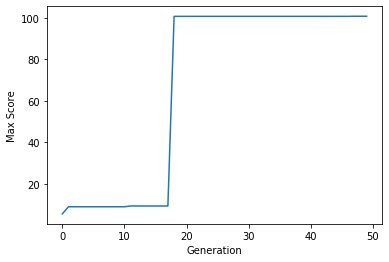

In [11]:
x = []
y = []
for i in range(50):
    x.append(i)
for score in allScores:
    y.append(score[1])
plt.xlabel('Generation')
plt.ylabel('Max Score')
plt.plot(x, y)
plt.show()

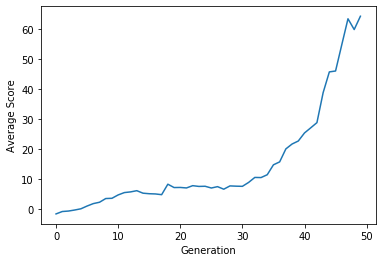

In [12]:
x = []
y = []
for i in range(50):
    x.append(i)

for score in allScores:
    y.append(score[2])
plt.xlabel('Generation')
plt.ylabel('Average Score')
plt.plot(x, y)
plt.show()